# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# Check the present working directory
!pwd

/Users/mohanadelemary/Desktop/Uda/Nano_3_Capstone/bertelsmann-arvato-customer-segmentation


### Download the data
If you do not have the required **data/** directory in your workspace, follow the instructions below. Use either one of the methods below. 

**Method 1** <br/>
You must [download this dataset](https://video.udacity-data.com/topher/2024/August/66b9ba05_arvato_data.tar/arvato_data.tar.gz) from the Downloads section in the classroom, and upload it into the workspace. After you upload the tar file to the present working  directory, **/workspace/cd1971 Data Scientist Capstone/Bertelsmann_Arvato Project Workspace/**,  in the Jupyter server, you can open a terminal and the run the following command to extract the dataset from the compressed file. 
```bash
!tar -xzvf arvato_data.tar.gz
```
This command will extract all the contents of arvato_data.tar.gz into the current directory. 

**Method 2** <br/>
Execute the Python code below to download the dataset. 


In [243]:
import requests
import tarfile
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, stats, chi2_contingency
from sklearn.impute import KNNImputer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (accuracy_score, recall_score, f1_score, roc_auc_score, classification_report,
                             roc_curve, precision_score, precision_recall_curve)
from imblearn.over_sampling import SMOTE
from skopt import BayesSearchCV
from skopt.space import Real, Integer

%matplotlib inline


pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Automatically adjust width
pd.set_option('display.max_colwidth', None)  

In [422]:


def download_and_extract(url, extract_to='.'):
    """
    Downloads a tar.gz file from a URL and extracts it to a directory.
    Args:
    - url (str): URL of the tar.gz file to download.
    - extract_to (str): Directory path to extract the contents of the tar.gz file.
    """
    # Get the filename from the URL
    filename = url.split('/')[-1]

    # Download the file
    print("Downloading the file...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.raw.read())
        print("Download completed.")
    else:
        print("Failed to download the file.")
        return

    # Extract the tar.gz file
    print("Extracting the file...")
    try:
        with tarfile.open(filename, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        print("Extraction completed.")
    except Exception as e:
        print(f"Failed to extract the file: {e}")
    finally:
        # Optionally remove the tar.gz file after extraction
        os.remove(filename)
        print("Downloaded tar.gz file removed.")

# URL of the tar.gz file
url = 'https://video.udacity-data.com/topher/2024/August/66b9ba05_arvato_data.tar/arvato_data.tar.gz'

# Call the function with the URL
download_and_extract(url)



Download completed.
Extracting the file...


/var/folders/df/vskq6r65025_c31r_18tdcpr0000gn/T/ipykernel_8402/762967868.py:26: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_to)


Extraction completed.
Downloaded tar.gz file removed.



### Important Note
>Delete the **data/** folder and the downloaded tar file, before you submit your code. The current workspace cannot save the files beyond 1GB of space in total. 




## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

>Note: If you experience "Kernel died" issue while running the codeblock below, then load less number of rows from the .csv files.

In [4]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

/var/folders/df/vskq6r65025_c31r_18tdcpr0000gn/T/ipykernel_8402/2693282953.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
/var/folders/df/vskq6r65025_c31r_18tdcpr0000gn/T/ipykernel_8402/2693282953.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')


### Part 0.1: Attributes Dictionary

We'll read in the two files explaining our features and values for reference and to understand how to interpret the population and customers data

In [5]:
#Reading in the two files explaining our attributes and values
attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')

In [6]:
info.head(20)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Information level,Attribute,Description,Additional notes
1,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
2,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-reference data
3,NaN,NaN,ANREDE_KZ,gender,NaN
4,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the preferred information and buying channels of consumers,"relating to the preferred information, marketing and buying channels of consumers as well as their cross-channel usage. The information basis is a survey on the consumer channel preferences combined via a statistical modell with AZ DIAS data"
5,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative household panel combined via a statistical modell with AZ DIAS data
6,NaN,NaN,FINANZ_SPARER,financial typology: money saver,NaN
7,NaN,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
8,NaN,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
9,NaN,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN


In [7]:
attributes_values.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Attribute,Description,Value,Meaning
1,NaN,AGER_TYP,best-ager typology,-1,unknown
2,NaN,NaN,NaN,0,no classification possible
3,NaN,NaN,NaN,1,passive elderly
4,NaN,NaN,NaN,2,cultural elderly


In [8]:
# Setting up the proper column names for attributes_values
attributes_values.columns = attributes_values.iloc[0]    # Set first row as header
attributes_values = attributes_values[1:].reset_index(drop=True)   # Drop the first row and reset index
attributes_values.head()

,NaN,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [9]:
# Columns Attribute & Description seem to have the key values at their first row.
# Subsequent rows contain the other values possible for the same attribute. 
# Therefore we simply need to forward-fill these columns

columns_to_fill = ['Attribute', 'Description']
attributes_values[columns_to_fill] = attributes_values[columns_to_fill].fillna(method='ffill')
attributes_values.head()

/var/folders/df/vskq6r65025_c31r_18tdcpr0000gn/T/ipykernel_8402/402792525.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  attributes_values[columns_to_fill] = attributes_values[columns_to_fill].fillna(method='ffill')


,NaN,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,AGER_TYP,best-ager typology,0,no classification possible
2,NaN,AGER_TYP,best-ager typology,1,passive elderly
3,NaN,AGER_TYP,best-ager typology,2,cultural elderly
4,NaN,AGER_TYP,best-ager typology,3,experience-driven elderly


In [10]:
# Setting up the proper column names for info

info.columns = info.iloc[0]    # Set first row as header
info = info[1:].reset_index(drop=True)   # Drop the first row and reset index
info.head()

,NaN,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-reference data
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the preferred information and buying channels of consumers,"relating to the preferred information, marketing and buying channels of consumers as well as their cross-channel usage. The information basis is a survey on the consumer channel preferences combined via a statistical modell with AZ DIAS data"
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative household panel combined via a statistical modell with AZ DIAS data


In [11]:
# Removing the Null column at the beginning of the attributes_values df

attributes_values = attributes_values.iloc[:, 1:]
info = info.iloc[:, 1:]
attributes_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [12]:
# Joining both df's into a single df on the attribute column

attributes = info.merge(attributes_values, how='outer', on='Attribute')
attributes.head()

,Information level,Attribute,Description_x,Additional notes,Description_y,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey,best-ager typology,-1,unknown
1,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey,best-ager typology,0,no classification possible
2,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey,best-ager typology,1,passive elderly
3,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey,best-ager typology,2,cultural elderly
4,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey,best-ager typology,3,experience-driven elderly


In [13]:
# The information level column is mostly nulls. very little cells with values

attributes['Information level'].value_counts()

Information level
Household             22
Microcell (RR4_ID)    10
Postcode               8
125m x 125m Grid       8
PLZ8                   7
Person                 6
Microcell (RR3_ID)     6
RR1_ID                 5
Building               1
Community              1
Name: count, dtype: int64

In [14]:
attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2271 entries, 0 to 2270
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Information level  74 non-null     object
 1   Attribute          2271 non-null   object
 2   Description_x      2176 non-null   object
 3   Additional notes   173 non-null    object
 4   Description_y      2258 non-null   object
 5   Value              2258 non-null   object
 6   Meaning            2247 non-null   object
dtypes: object(7)
memory usage: 124.3+ KB


In [15]:
def fetch_contains(search_string, df=attributes, ):

    """
    PURPOSE:
    - Provide a quick way to query and understand any attribute that we'll be working with in the population and customer data
    
    INPUT: 
    - Search_string: String of characters to look for in all cells of a dataframe
    - df: specifies the dataframe to query, by default it is the attributes dataframe
    
    OUTPUT:
    - dataframe containing all rows where the string queried was found
    
    """
    # Create a mask that checks for substring containment
    mask = df.apply(lambda row: row.astype(str).str.contains(search_string, case=False, na=False).any(), axis=1)

    # Use the mask with query
    result = attributes[mask]

    return result

In [16]:
# Testing function
fetch_contains('ager')

,Information level,Attribute,Description_x,Additional notes,Description_y,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey,best-ager typology,-1,unknown
1,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey,best-ager typology,0,no classification possible
2,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey,best-ager typology,1,passive elderly
3,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey,best-ager typology,2,cultural elderly
4,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey,best-ager typology,3,experience-driven elderly
89,NaN,CAMEO_DEU_2015,CAMEO_4.0: specific group,NaN,CAMEO classification 2015 - detailled classification,1B,Wealthy Best Ager
105,NaN,CAMEO_DEU_2015,CAMEO_4.0: specific group,NaN,CAMEO classification 2015 - detailled classification,4E,Golden Ager
736,NaN,GFK_URLAUBERTYP,vacation habits,NaN,vacation habits,7,Golden ager
1906,NaN,LP_FAMILIE_FEIN,family type fine,NaN,familytyp fine,4,single parent with teenager
1909,NaN,LP_FAMILIE_FEIN,family type fine,NaN,familytyp fine,7,family with teenager


### Part 0.2: Customers & Population Data - Data Cleaning

Given that the dataframes are closely related and will be compared to each other in the end, it makes sense to do the analysis and cleaning for both in parallel


In [17]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [18]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [19]:
# Looking into the df's shapes
print(azdias.shape)
print(customers.shape)

(891221, 366)
(191652, 369)


In [20]:
# Checking for duplicates
print(azdias.duplicated().sum())
print(customers.duplicated().sum())

0
0


In [21]:
# Looking into the updated df's shapes
print(azdias.shape)
print(customers.shape)

(891221, 366)
(191652, 369)


In [23]:
# Creating the nulls table from the customers df
c_null = create_null_table(customers)

In [24]:
# Creating the nulls table from the azdias population df

p_null = create_null_table(azdias)


In [25]:
c_null.head(10)

,feature,null_count,percentage
7,ALTER_KIND4,191416,0.998769
6,ALTER_KIND3,190377,0.993347
5,ALTER_KIND2,186552,0.973389
4,ALTER_KIND1,179886,0.938607
300,KK_KUNDENTYP,111937,0.584064
100,EXTSEL992,85283,0.444989
148,KBA05_KRSOBER,55980,0.292092
144,KBA05_KRSHERST1,55980,0.292092
136,KBA05_GBZ,55980,0.292092
137,KBA05_HERST1,55980,0.292092


In [26]:
p_null.head(10)

,feature,null_count,percentage
7,ALTER_KIND4,890016,0.998648
6,ALTER_KIND3,885051,0.993077
5,ALTER_KIND2,861722,0.966900
4,ALTER_KIND1,810163,0.909048
100,EXTSEL992,654153,0.733996
300,KK_KUNDENTYP,584612,0.655967
8,ALTERSKATEGORIE_FEIN,262947,0.295041
85,D19_VERSAND_ONLINE_QUOTE_12,257113,0.288495
62,D19_LOTTO,257113,0.288495
36,D19_BANKEN_ONLINE_QUOTE_12,257113,0.288495


In [27]:
# Creating a function to detect numerical columns then fill the nulls with the column's mean, rounded to the nearest integer


def create_null_table(df):

    """
    INPUT: 
    df: dataframe to be processed

    OUTPUT:
    null_df: dataframe of all the df's columns with the null values within each column and the null% out of all rows in the df.
    output is sorted descendingly
    
    
    """
    null_df = df.isna().sum()
    null_df = null_df.reset_index()
    null_df = null_df.sort_values(by=0,ascending=False)
    null_df.columns = ['feature', 'null_count']

    null_df['percentage'] = null_df['null_count']/(df.shape[0])

    return null_df

def drop_mostly_na_cols(df):
    df_null = create_null_table(df)
    df_drop_cols = df_null.loc[df_null['percentage'] > 0.5, 'feature'].tolist()
    
    if df_drop_cols:
        print(f"Dropping columns with more than 50% Null values: {df_drop_cols}")
        df.drop(columns=df_drop_cols, inplace=True)
    else:
        print("No columns with more than 50% Null values to drop.")
    
    return df



def fill_na_with_mean_and_convert(df, exclude_cols=None):
    """
    Fills NaN values in numeric columns with the mean and converts columns to int.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to process.
    exclude_cols (list): A list of columns to exclude from processing.
    
    Returns:
    pd.DataFrame: The DataFrame with NaNs filled and columns converted to int.
    """
    if exclude_cols is None:
        exclude_cols = []

    # Step 1: Filter columns with dtype float or int, excluding specified columns
    filtered_columns = df.select_dtypes(include=['float', 'int']).drop(columns=exclude_cols, errors='ignore')

    # Step 2: Fill NaN values with the mean of each column
    filled_columns = filtered_columns.fillna(filtered_columns.mean())

    # Step 3: Convert columns to int
    filled_columns = filled_columns.astype(int)

    # Step 4: Update the original DataFrame
    df.update(filled_columns)

    print("Numerical columns' nulls have been successfully replaced with the respective column's mean.")

    
    return df


def fill_na_with_mode_and_convert(df):


    
    df_null = create_null_table(df)    

    df_null_list = df_null.loc[df_null['null_count'] > 0, 'feature'].tolist()

    object_columns = df.select_dtypes(include='object').columns
    
    # Filter df_null_list to include only features that are also in object_columns
    df_obj_null_list = [feature for feature in df_null_list if feature in object_columns]
    
    for feature in df_obj_null_list:

        most_frequent_value = df[feature].mode()[0]
    
        df[feature].fillna(most_frequent_value, inplace=True)

    print("Categorical columns' nulls have been successfully replaced with the respective column's mode.")

    return df

def clean_nulls(df, exclude_cols=None):

    # Drop columns with more than 50% nulls
    df = drop_mostly_na_cols(df)
    
    # Fill numerical columns' nulls
    df = fill_na_with_mean_and_convert(df, exclude_cols=exclude_cols)
    
    # Fill categorical columns' nulls
    df = fill_na_with_mode_and_convert(df)

    # Print out the remaining null count
    print(f"Remaining Nulls in df: {df.isna().any().sum()}")
    
    return df


In [28]:
# Filling the numerical nulls in azdias population df, while excluding the LNR identifier column from the process

azdias = clean_nulls(azdias, exclude_cols=['LNR'])

Dropping columns with more than 50% Null values: ['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'EXTSEL992', 'KK_KUNDENTYP']
Numerical columns' nulls have been successfully replaced with the respective column's mean.


/var/folders/df/vskq6r65025_c31r_18tdcpr0000gn/T/ipykernel_8402/3518670280.py:88: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(most_frequent_value, inplace=True)


Categorical columns' nulls have been successfully replaced with the respective column's mode.
Remaining Nulls in df: 0


In [29]:
# Filling the numerical nulls in customers df, while excluding the LNR identifier column and the 3 unique customer columns from the process

customers = clean_nulls(customers, exclude_cols=['LNR','CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])

Dropping columns with more than 50% Null values: ['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'KK_KUNDENTYP']
Numerical columns' nulls have been successfully replaced with the respective column's mean.
Categorical columns' nulls have been successfully replaced with the respective column's mode.
Remaining Nulls in df: 0


/var/folders/df/vskq6r65025_c31r_18tdcpr0000gn/T/ipykernel_8402/3518670280.py:88: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(most_frequent_value, inplace=True)


### Part 0.3: Customers & Population Data - Data Pre-processing & Analysis

This section tackles all pre-processing steps and the general analysis to determine key differences between the customers dataset and 
population dataset


In [30]:
# Exclude specific columns to create `cseg` and 'pseg' for customer segment and population segment.
cseg = customers.drop(columns=['LNR','CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP','EINGEFUEGT_AM'])
pseg = azdias.drop(columns=['LNR','EINGEFUEGT_AM'])


In [31]:
pseg.select_dtypes(include=['object']).columns


Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'],
      dtype='object')

In [32]:
# List of columns to one-hot encode
columns_to_encode = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 
                     'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ']

# One-hot encoding the specified columns
pseg_encoded = pd.get_dummies(pseg, columns=columns_to_encode, drop_first=True)

# Check the result
pseg_encoded.columns


Index(['AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL',
       ...
       'D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK',
       'D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE',
       'D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST',
       'D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL',
       'D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT',
       'D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST',
       'D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN',
       'D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT',
       'D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST', 'OST_WEST_KZ_W'],
      dtype='object', length=492)

In [33]:
# List of columns to one-hot encode
columns_to_encode = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 
                     'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ']

# One-hot encoding the specified columns
cseg_encoded = pd.get_dummies(cseg, columns=columns_to_encode, drop_first=True)

# Check the result
cseg_encoded.columns


Index(['AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL',
       ...
       'D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK',
       'D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE',
       'D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST',
       'D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL',
       'D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT',
       'D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST',
       'D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN',
       'D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT',
       'D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST', 'OST_WEST_KZ_W'],
      dtype='object', length=493)

In [34]:
pseg_encoded.shape


(891221, 492)

In [41]:
# Standardize the data
scaler = StandardScaler()
scaled_p_data = scaler.fit_transform(pseg_encoded)


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



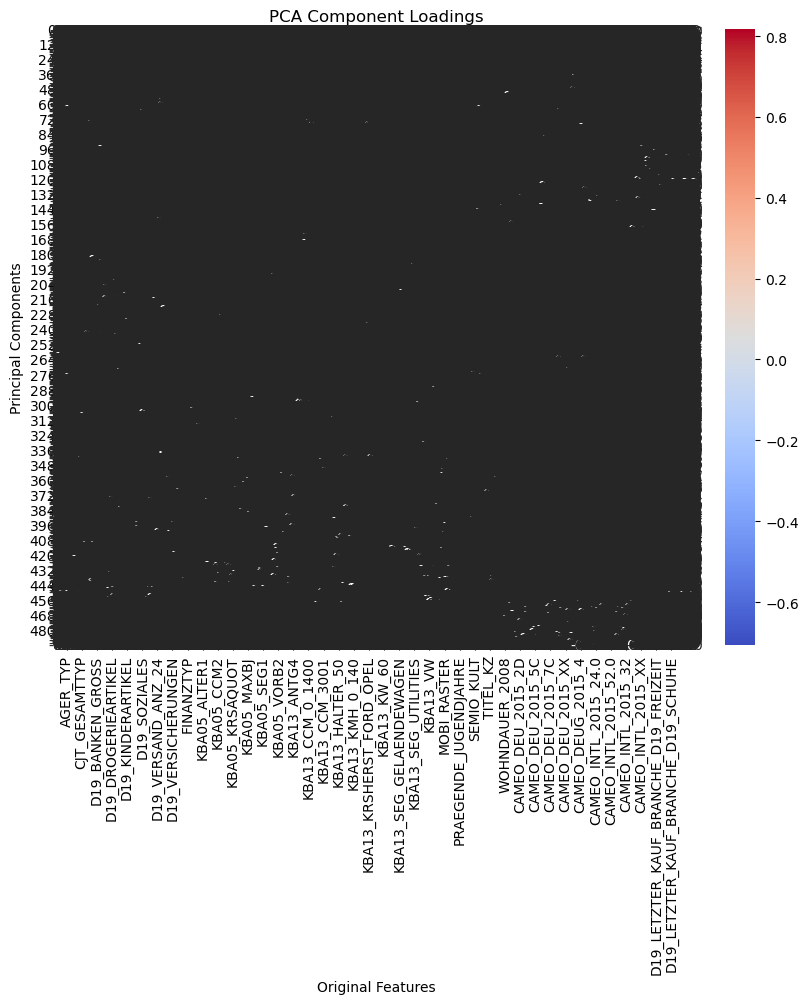

In [46]:
# Perform PCA
pca = PCA()
pca.fit(scaled_p_data)

# Get the component loadings
loadings = pca.components_

# Check that the number of columns in the DataFrame matches the number of features in PCA
if loadings.shape[1] == pseg_encoded.shape[1]:
    print("The number of features in the PCA loadings matches the number of columns in the DataFrame.")
else:
    print(f"Warning: PCA components' column count ({loadings.shape[1]}) does not match DataFrame columns ({pseg_encoded.shape[1]}).")

# Create a DataFrame of the loadings with feature names as columns
loadings_df = pd.DataFrame(loadings, columns=pseg_encoded.columns)

# Print the loadings for each component
print("PCA Component Loadings:")
for i, component in enumerate(loadings_df.values):
    print(f"\nPrincipal Component {i + 1}:")
    for j, value in enumerate(component):
        print(f"{pseg_encoded.columns[j]}: {value:.4f}")
        
# Optionally, you can display the component loadings as a DataFrame for better readability
print("\nPCA Loadings DataFrame:")
print(loadings_df)

# Visualize the components with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(loadings_df, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("PCA Component Loadings")
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.show()


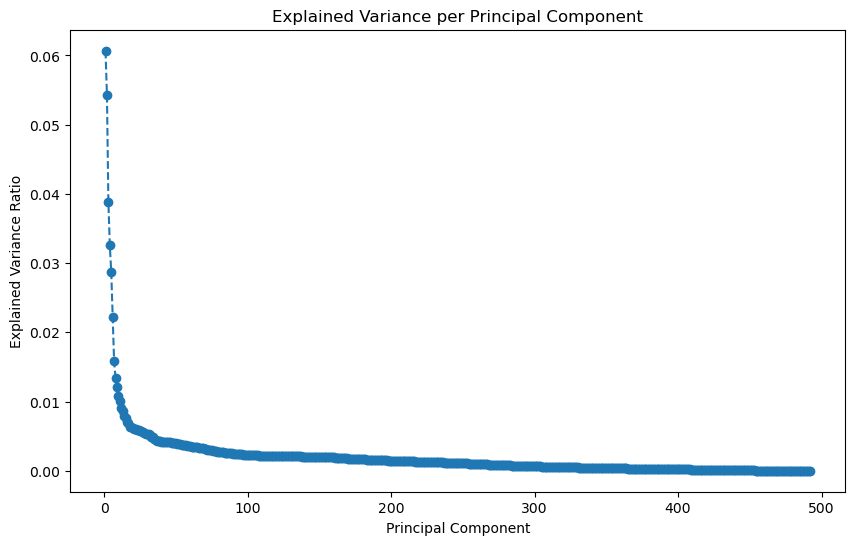

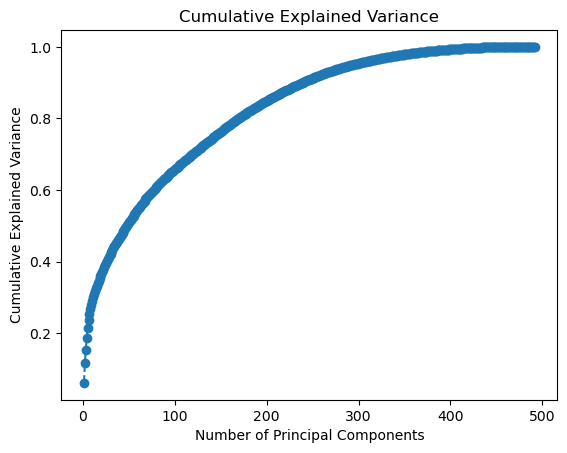

Principal Component 1: 6.07% cumulative explained variance
Principal Component 2: 11.50% cumulative explained variance
Principal Component 3: 15.39% cumulative explained variance
Principal Component 4: 18.64% cumulative explained variance
Principal Component 5: 21.52% cumulative explained variance
Principal Component 6: 23.74% cumulative explained variance
Principal Component 7: 25.32% cumulative explained variance
Principal Component 8: 26.66% cumulative explained variance
Principal Component 9: 27.87% cumulative explained variance
Principal Component 10: 28.95% cumulative explained variance
Principal Component 11: 29.96% cumulative explained variance
Principal Component 12: 30.86% cumulative explained variance
Principal Component 13: 31.72% cumulative explained variance
Principal Component 14: 32.52% cumulative explained variance
Principal Component 15: 33.28% cumulative explained variance
Principal Component 16: 33.99% cumulative explained variance
Principal Component 17: 34.67% cum

In [49]:
# Plot the explained variance ratio (Scree plot)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance per Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Print the cumulative variance to find the optimal number of components
for i, var in enumerate(cumulative_variance):
    print(f"Principal Component {i + 1}: {var * 100:.2f}% cumulative explained variance")

In [51]:
# 239 components explain 90% of the cumulative variance

optimal_components = 239  # Replace with the optimal number based on your analysis

# Perform PCA with the selected number of components
pca = PCA(n_components=optimal_components)
reduced_data = pca.fit_transform(scaled_p_data)

# Convert reduced data back to a DataFrame for further analysis
reduced_p_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(optimal_components)])

print(reduced_p_df.head())


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.869094 -2.731311 -6.963729  1.040868  2.958499  6.783553 -0.874007   
1 -4.568002 -1.684648  1.897054  4.851771  2.448698 -6.026729  1.143098   
2  0.194146 -0.223861 -2.335172  2.422902 -0.126187 -4.937231  4.135234   
3  3.010391  1.712890 -6.587967 -0.860330 -1.270350 -2.939170 -0.519141   
4  7.810472  0.594023  9.345876  4.391189 -2.307470  3.304319 -2.982238   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  0.866763 -0.106535 -0.360046  0.432334 -0.557173 -0.622358  0.236205   
1 -2.151387 -2.539018  1.957996  0.229777 -2.530896  2.715761  1.500560   
2 -4.447477  1.708935 -0.041642  0.263825  0.271434 -2.064955  0.984845   
3 -0.862617 -2.123281 -2.916836 -0.876805 -1.034498  2.163743 -1.039452   
4  3.118670  0.846216 -4.634064  5.660242  0.040264  1.731384 -4.922199   

       PC15      PC16      PC17      PC18      PC19      PC20      PC21  \
0  0.399798  0.375065 -

# Running a two-sample t-test across the mean of every feature in both tables to determine statistical significance

p_values = {}  # Dictionary to store p-values for each feature
mean_diff = {}  # Dictionary to store mean difference for each feature

for feature in cseg.columns:
    customer_values = cseg[feature].dropna()
    population_values = pseg[feature].dropna()
    
    # Mean difference
    mean_diff[feature] = customer_values.mean() - population_values.mean()
    
    # T-test
    t_stat, p_val = ttest_ind(customer_values, population_values, equal_var=False)
    p_values[feature] = p_val

# Filter p-values for significance, e.g., p < 0.05
significant_features = {k: v for k, v in p_values.items() if v < 0.05}


# Running a cohen's d test across the mean of every feature in both tables to determine the magnitude of the difference


cohen_d_values = {}  # Dictionary to store Cohen's d values for each feature

for feature in cseg.columns:
    customer_values = cseg[feature].dropna()
    population_values = pseg[feature].dropna()
    
    # Calculate pooled standard deviation
    pooled_std = np.sqrt(
        ((len(customer_values) - 1) * customer_values.std()**2 + 
         (len(population_values) - 1) * population_values.std()**2) / 
        (len(customer_values) + len(population_values) - 2)
    )
    
    # Calculate Cohen's d
    cohen_d = (customer_values.mean() - population_values.mean()) / pooled_std
    cohen_d_values[feature] = cohen_d


results_df = pd.DataFrame({
    'Mean Difference': mean_diff,
    'P-value': p_values,
    'Cohen\'s d': cohen_d_values
})

results_df['Cohen\'s d'] = results_df['Cohen\'s d'].round(1)

# Filter results to show significant differences only
significant_results_df = results_df[(results_df['P-value'] < 0.05) & (results_df['Cohen\'s d'].abs() > 0.5)]
significant_results_df = significant_results_df.sort_values(by='Cohen\'s d', ascending=False)
significant_results_df

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

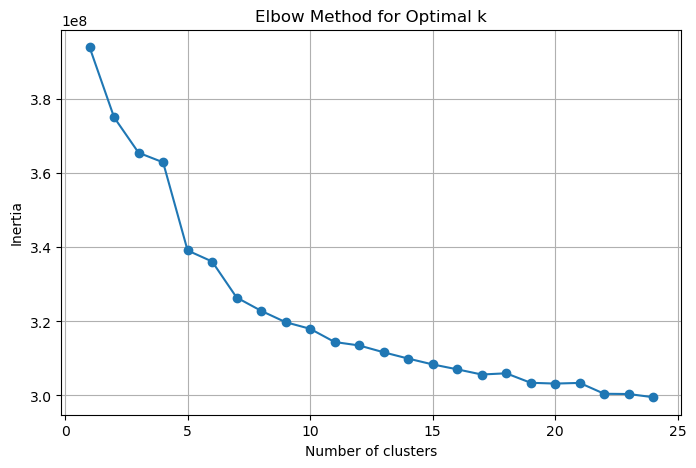

In [52]:
# Running an inertia model across no. of clusters between 1 and 25 to determine the optimal 
# No. of Clusters for our classification model.

inertia = []
range_n_clusters = range(1, 25)  # You can adjust this range as needed
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(reduced_p_df)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()


In [54]:
kmeans = KMeans(n_clusters=12, random_state=42)

kmeans.fit(reduced_p_df)

reduced_p_df['cluster'] = kmeans.labels_

/var/folders/df/vskq6r65025_c31r_18tdcpr0000gn/T/ipykernel_8402/2785373892.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


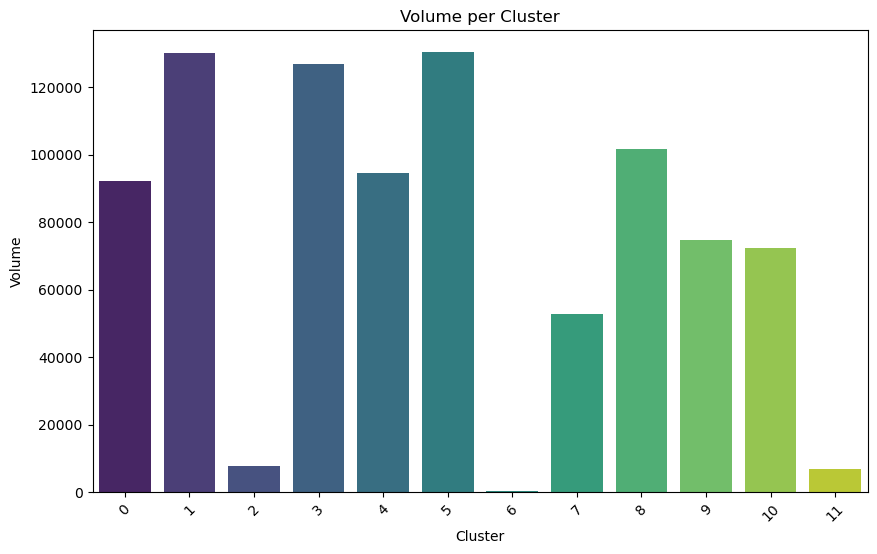

In [56]:
# Count the number of data points in each cluster
cluster_counts = reduced_p_df['cluster'].value_counts().sort_index()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('Volume per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.show()


In [58]:
cseg_encoded.drop(columns='EXTSEL992',inplace=True)

# Standardize the data
scaled_c_data = scaler.transform(cseg_encoded)


In [59]:
reduced_c_data = pca.transform(scaled_c_data)

# Convert the reduced customer segmentation data to a DataFrame
reduced_c_df = pd.DataFrame(reduced_c_data, columns=[f'PC{i+1}' for i in range(optimal_components)])

print(reduced_c_df.head())


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  5.932564  3.267724 -6.999089  0.846077 -4.566500 -2.452057 -1.510696   
1  2.154194 -1.753648 -4.863042  1.972359 -1.364486  2.825020 -0.187187   
2 -3.260105  1.893705 -3.338594  0.449123 -7.085840  0.753855 -4.167790   
3  4.543874  1.234464 -5.338520 -2.845302 -2.792095  0.010340  3.003465   
4  5.472865 -2.170573  8.348414  0.972889 -0.763217  2.212337 -4.921289   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  3.298626  0.447573 -0.271202  0.868949 -1.567554 -0.618395  1.553906   
1  3.156987  0.852339  0.776537 -0.256980  1.895514  0.782343 -1.215804   
2 -1.084089  0.886527 -4.163889 -4.421762  0.941330  4.833661 -1.437551   
3  3.389059 -3.188090 -1.973070  1.968116  0.025996 -2.148788  0.361142   
4  0.486929  2.499616 -0.856087  2.123555  0.146242 -0.533424  1.671428   

       PC15      PC16      PC17      PC18      PC19      PC20      PC21  \
0 -0.945285  3.143870  

In [60]:
# Now, use the same KMeans model to predict the cluster labels for the customer segmentation data (reduced_c_df)
reduced_c_df['cluster'] = kmeans.predict(reduced_c_df)

# Print the first few rows of the reduced customer segmentation data with cluster labels
print(reduced_c_df.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  5.932564  3.267724 -6.999089  0.846077 -4.566500 -2.452057 -1.510696   
1  2.154194 -1.753648 -4.863042  1.972359 -1.364486  2.825020 -0.187187   
2 -3.260105  1.893705 -3.338594  0.449123 -7.085840  0.753855 -4.167790   
3  4.543874  1.234464 -5.338520 -2.845302 -2.792095  0.010340  3.003465   
4  5.472865 -2.170573  8.348414  0.972889 -0.763217  2.212337 -4.921289   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  3.298626  0.447573 -0.271202  0.868949 -1.567554 -0.618395  1.553906   
1  3.156987  0.852339  0.776537 -0.256980  1.895514  0.782343 -1.215804   
2 -1.084089  0.886527 -4.163889 -4.421762  0.941330  4.833661 -1.437551   
3  3.389059 -3.188090 -1.973070  1.968116  0.025996 -2.148788  0.361142   
4  0.486929  2.499616 -0.856087  2.123555  0.146242 -0.533424  1.671428   

       PC15      PC16      PC17      PC18      PC19      PC20      PC21  \
0 -0.945285  3.143870  

<Figure size 1200x600 with 0 Axes>

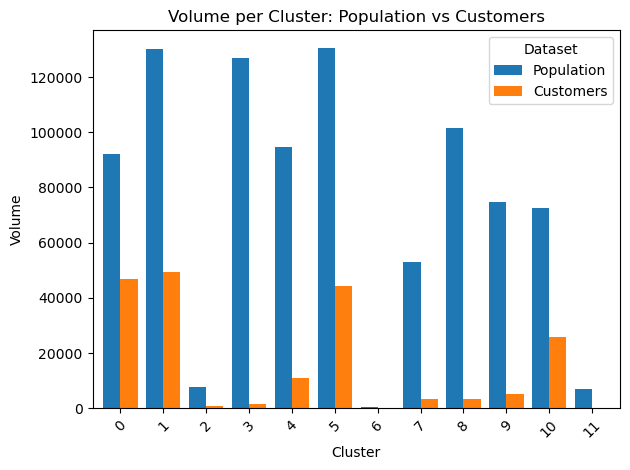

In [62]:
# Count the number of data points in each cluster for the population and customer datasets
cluster_counts_population = reduced_p_df['cluster'].value_counts().sort_index()
cluster_counts_customers = reduced_c_df['cluster'].value_counts().sort_index()

# Combine the cluster counts into a single DataFrame for easier plotting
cluster_counts_combined = pd.DataFrame({
    'Population': cluster_counts_population,
    'Customers': cluster_counts_customers
}).fillna(0)  # Fill NaN values with 0 (if any clusters are missing in one of the datasets)

# Plotting the combined bar chart
plt.figure(figsize=(12, 6))
cluster_counts_combined.plot(kind='bar', width=0.8)

plt.title('Volume per Cluster: Population vs Customers')
plt.xlabel('Cluster')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()

# Display the plot
plt.show()

In [63]:
# Calculate the percentage of total population and total customers in each cluster
population_percentages = (cluster_counts_population / cluster_counts_population.sum()) * 100
customer_percentages = (cluster_counts_customers / cluster_counts_customers.sum()) * 100

# Create a DataFrame to view the comparison
comparison_df = pd.DataFrame({
    'Population Percentage': population_percentages,
    'Customer Percentage': customer_percentages
}).fillna(0)  # Fill missing values (if any clusters are missing from customer data)

# Print the comparison
print(comparison_df)


         Population Percentage  Customer Percentage
cluster                                            
0                    10.347602            24.374909
1                    14.614894            25.854674
2                     0.879804             0.398639
3                    14.252694             0.852587
4                    10.604440             5.632083
5                    14.632734            23.147684
6                     0.041853             0.065744
7                     5.939604             1.791268
8                    11.400203             1.666041
9                     8.383442             2.632375
10                    8.124023            13.495815
11                    0.778707             0.088181


In [67]:
# Calculate percentage difference between customer and population percentages
comparison_df['Percentage Difference'] = comparison_df['Customer Percentage'] - comparison_df['Population Percentage']

# Print the comparison with the difference
print(comparison_df.sort_values(by='Percentage Difference', ascending=False))


         Population Percentage  Customer Percentage  Percentage Difference
cluster                                                                   
0                    10.347602            24.374909              14.027307
1                    14.614894            25.854674              11.239781
5                    14.632734            23.147684               8.514950
10                    8.124023            13.495815               5.371792
6                     0.041853             0.065744               0.023891
2                     0.879804             0.398639              -0.481165
11                    0.778707             0.088181              -0.690526
7                     5.939604             1.791268              -4.148337
4                    10.604440             5.632083              -4.972357
9                     8.383442             2.632375              -5.751067
8                    11.400203             1.666041              -9.734162
3                    14.2

In [65]:
# Create a contingency table with the counts of customers and population in each cluster
contingency_table = pd.concat([cluster_counts_population, cluster_counts_customers], axis=1, keys=['Population', 'Customers'])

# Perform the Chi-Square Test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the test result
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Counts:\n{expected}")

# Interpretation of p-value
if p_value < 0.05:
    print("There is a significant difference between the population and customer distribution across clusters.")
else:
    print("There is no significant difference between the population and customer distribution across clusters.")


Chi-Square Statistic: 105507.63079945113
P-value: 0.0
Degrees of Freedom: 11
Expected Counts:
[[1.14345625e+05 2.45893753e+04]
 [1.47979789e+05 3.18222108e+04]
 [7.08204628e+03 1.52295372e+03]
 [1.05886674e+05 2.27703261e+04]
 [8.66659756e+04 1.86370244e+04]
 [1.43840845e+05 3.09321546e+04]
 [4.10684613e+02 8.83153869e+01]
 [4.63917240e+04 9.97627601e+03]
 [8.62470608e+04 1.85469392e+04]
 [6.56436969e+04 1.41163031e+04]
 [8.08760632e+04 1.73919368e+04]
 [5.85081546e+03 1.25818454e+03]]
There is a significant difference between the population and customer distribution across clusters.


In [76]:
# Add cluster labels to the original data
cseg_encoded['cluster'] = reduced_c_df['cluster']

# Group by cluster and calculate summary statistics for each feature
cluster_summary = cseg_encoded.groupby('cluster').mean()

# Print the cluster summary
print(cluster_summary)


         AGER_TYP  AKT_DAT_KL   ALTER_HH  ALTERSKATEGORIE_FEIN  \
cluster                                                          
0       -0.997881    1.005651  10.990260              9.999850   
1        0.992493    1.616052   9.173094              8.904825   
2        0.657068    3.554974   6.556283              7.346859   
3       -0.870257    3.203182  12.104651             13.883109   
4        1.120252    2.013804   8.576431              8.846026   
5        0.550121    1.502243  15.180466             12.046300   
6        0.444444    4.047619   7.515873              8.349206   
7        0.674629    1.784736  11.963880             11.375765   
8        0.115878    2.793924  11.271218             12.017538   
9        0.073142    2.237265  14.095937             13.737562   
10       0.953992    1.907172   9.657452              9.541427   
11       0.420118    3.100592   9.242604             10.224852   

         ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
clu

In [83]:

# Specify the target clusters you want to compare
target_clusters = [0, 1, 5, 10]
p_values = {}  # Dictionary to store p-values for each feature
mean_diff = {}  # Dictionary to store mean difference for each feature

# Loop through each of the target clusters
for cluster in target_clusters:
    p_values[cluster] = {}  # Store p-values for the current cluster
    mean_diff[cluster] = {}  # Store mean differences for the current cluster
    
    # Loop through each feature in the cluster summary
    for feature in cluster_summary.columns:
        # Extract the values for the current cluster (cluster `cluster`)
        cluster_values = cluster_summary.loc[cluster, feature]
        
        # Extract values for the other clusters (excluding the current cluster)
        other_clusters_values = cluster_summary.loc[cluster_summary.index != cluster, feature].dropna()
        
        # Repeat the scalar value for the current cluster to match the size of the other clusters
        cluster_values_repeated = [cluster_values] * len(other_clusters_values)
        
        # Mean difference
        mean_diff[cluster][feature] = cluster_values - other_clusters_values.mean()
        
        # T-test
        t_stat, p_val = ttest_ind(cluster_values_repeated, other_clusters_values, equal_var=False)
        p_values[cluster][feature] = p_val

# Filter significant p-values (e.g., p < 0.05) for each cluster
significant_features = {}
for cluster in target_clusters:
    significant_features[cluster] = {k: v for k, v in p_values[cluster].items() if v < 0.05}

# Output significant features for each cluster
for cluster in target_clusters:
    print(f"Significant features for Cluster {cluster}:")
    print(significant_features[cluster])
    print()  # Add a blank line for better readability

Significant features for Cluster 0:
{'AGER_TYP': 5.439667657104121e-06, 'AKT_DAT_KL': 0.00015996089664718047, 'ANZ_HAUSHALTE_AKTIV': 0.0456266375608919, 'ANZ_HH_TITEL': 0.0043999292918363705, 'ANZ_KINDER': 0.003079583504087438, 'ANZ_TITEL': 0.001636965905402306, 'ARBEIT': 4.7891117534329475e-06, 'CJT_GESAMTTYP': 1.3911699166106909e-08, 'CJT_KATALOGNUTZER': 0.0006523380246649732, 'CJT_TYP_1': 1.6194884780211805e-06, 'CJT_TYP_2': 8.686595347607933e-07, 'CJT_TYP_3': 0.0015840657174964507, 'CJT_TYP_4': 0.001430793278211536, 'CJT_TYP_5': 0.0019952363837172325, 'CJT_TYP_6': 0.0011182658161999258, 'D19_BANKEN_ANZ_12': 0.02811507042248725, 'D19_BANKEN_ANZ_24': 0.010500360844707677, 'D19_BANKEN_DATUM': 0.003085555579483129, 'D19_BANKEN_DIREKT': 0.0010691766714675194, 'D19_BANKEN_GROSS': 0.0003718493049470362, 'D19_BANKEN_LOKAL': 0.010879298638078894, 'D19_BANKEN_ONLINE_DATUM': 0.0065793305499629575, 'D19_BANKEN_ONLINE_QUOTE_12': 0.025271815795702497, 'D19_BANKEN_REST': 0.001388717884703479, 'D1

In [84]:
# Specify the target clusters you want to compare
target_clusters = [0, 1, 5, 10]
cohen_d_values = {}  # Dictionary to store Cohen's d values for each feature

# Loop through each of the target clusters
for cluster in target_clusters:
    cohen_d_values[cluster] = {}  # Store Cohen's d values for the current cluster
    
    # Loop through each feature in the cluster summary
    for feature in cluster_summary.columns:
        # Extract the values for the current cluster (cluster `cluster`)
        cluster_values = cluster_summary.loc[cluster, feature]
        
        # Extract values for the other clusters (excluding the current cluster)
        other_clusters_values = cluster_summary.loc[cluster_summary.index != cluster, feature].dropna()
        
        # Calculate pooled standard deviation (for the values from other clusters)
        pooled_std = np.std(other_clusters_values, ddof=1)  # Using ddof=1 for sample std
        
        # Calculate Cohen's d: (mean of group 1 - mean of group 2) / pooled standard deviation
        cohen_d = (cluster_values - other_clusters_values.mean()) / pooled_std
        cohen_d_values[cluster][feature] = cohen_d

# Now cohen_d_values contains the Cohen's d for each feature per cluster
# You can filter by significant Cohen's d values or output them directly

# Output the Cohen's d values for each cluster
for cluster in target_clusters:
    print(f"Cohen's d values for Cluster {cluster}:")
    print(cohen_d_values[cluster])
    print()  # Add a blank line for better readability

Cohen's d values for Cluster 0:
{'AGER_TYP': -2.6320540948924367, 'AKT_DAT_KL': -1.766125322565214, 'ALTER_HH': 0.18773606167071913, 'ALTERSKATEGORIE_FEIN': -0.25990238365578094, 'ANZ_HAUSHALTE_AKTIV': -0.6880630726922384, 'ANZ_HH_TITEL': -1.1030816481873686, 'ANZ_KINDER': -1.1686181841779706, 'ANZ_PERSONEN': 0.3605357996736554, 'ANZ_STATISTISCHE_HAUSHALTE': -0.6208972237199812, 'ANZ_TITEL': -1.2874572165859932, 'ARBEIT': -2.6697872517757797, 'BALLRAUM': 0.023487688534262814, 'CJT_GESAMTTYP': 4.976195543646554, 'CJT_KATALOGNUTZER': 1.4681347599461692, 'CJT_TYP_1': 3.008981192015528, 'CJT_TYP_2': 3.219478900750085, 'CJT_TYP_3': 1.2937425755936727, 'CJT_TYP_4': 1.3132869719795508, 'CJT_TYP_5': 1.2498237318091916, 'CJT_TYP_6': 1.3610902349121317, 'D19_BANKEN_ANZ_12': -0.7734754997223988, 'D19_BANKEN_ANZ_24': -0.9469111888668996, 'D19_BANKEN_DATUM': 1.1682595159080456, 'D19_BANKEN_DIREKT': -1.3698717970825083, 'D19_BANKEN_GROSS': -1.583800125590521, 'D19_BANKEN_LOKAL': -0.9406287159098938,

In [ ]:
for cluster in target_clusters:
    
    cluster_results_df = pd.DataFrame({
    'Mean Difference': mean_diff,
    'P-value': p_values,
    'Cohen\'s d': cohen_d_values
})

cluster_results_df['Cohen\'s d'] = cluster_results_df['Cohen\'s d'].round(1)

# Filter results to show significant differences only
significant_cluster_results_df = cluster_results_df[(cluster_results_df['P-value'] < 0.05) & (cluster_results_df['Cohen\'s d'].abs() > 0.5)]
significant_cluster_results_df = significant_cluster_results_df.sort_values(by='Cohen\'s d', ascending=False)
significant_cluster_results_df


In [86]:
# Create an empty dictionary to store the DataFrames for each cluster
cluster_dfs = {}

# Now let's create and filter the DataFrame for each cluster
for cluster in target_clusters:
    # Create a DataFrame for the current cluster results
    cluster_results_df = pd.DataFrame({
        'Feature': list(cluster_summary.columns),
        'Mean Difference': [mean_diff[cluster].get(feature, None) for feature in cluster_summary.columns],
        'P-value': [p_values[cluster].get(feature, None) for feature in cluster_summary.columns],
        'Cohen\'s d': [cohen_d_values[cluster].get(feature, None) for feature in cluster_summary.columns]
    })
    
    # Round Cohen's d values
    cluster_results_df['Cohen\'s d'] = cluster_results_df['Cohen\'s d'].round(1)
    
    # Filter results to show significant differences (p-value < 0.05 and Cohen's d > 0.5)
    significant_cluster_results_df = cluster_results_df[
        (cluster_results_df['P-value'] < 0.05) & 
        (cluster_results_df['Cohen\'s d'].abs() > 0.5)
    ]
    
    # Sort by Cohen's d value
    significant_cluster_results_df = significant_cluster_results_df.sort_values(by='Cohen\'s d', ascending=False)
    
    # Save the filtered DataFrame to the dictionary
    cluster_dfs[f'cluster_{cluster}_results'] = significant_cluster_results_df

# Now cluster_dfs will hold the DataFrame for each cluster, e.g., cluster_0_results, cluster_1_results, etc.
# To access a specific cluster's DataFrame, you can do something like:
# cluster_0_results = cluster_dfs['cluster_0_results']
# cluster_1_results = cluster_dfs['cluster_1_results']


In [96]:
cluster_0_results = cluster_dfs['cluster_0_results']
cluster_1_results = cluster_dfs['cluster_1_results']
cluster_5_results = cluster_dfs['cluster_5_results']
cluster_10_results = cluster_dfs['cluster_10_results']

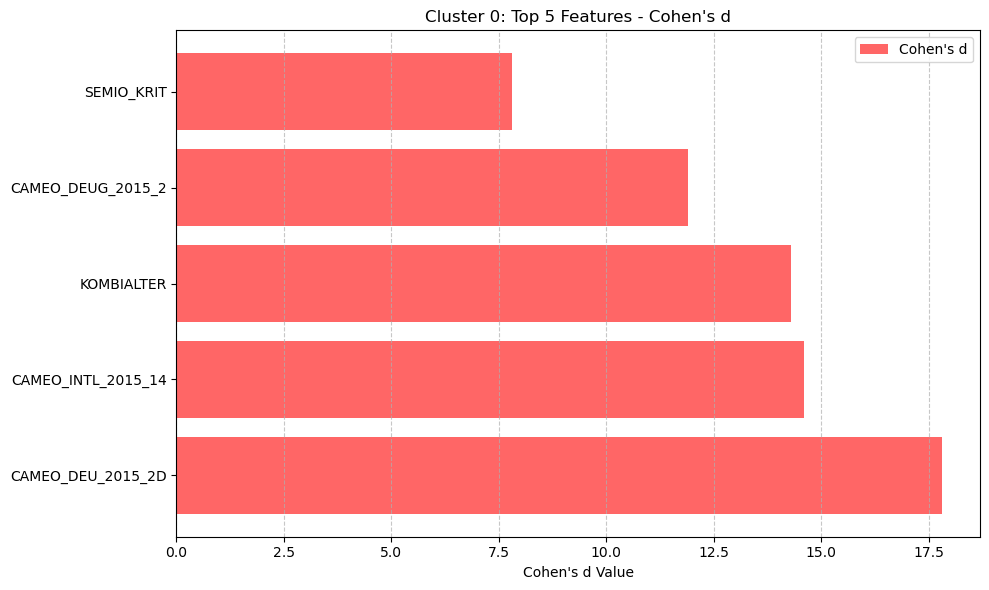

In [178]:
# Cluster 0
# Sort by the absolute value of Cohen's d in descending order and select the top 20
top_5_features = cluster_0_results.reindex(cluster_0_results['Cohen\'s d'].sort_values(ascending=False).head(5).index)

# Plotting only Cohen's d for the top 20 features
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Cohen's d
ax.barh(top_5_features['Feature'], top_5_features['Cohen\'s d'], color='red', alpha=0.6, label="Cohen's d")

# Adding labels and title
ax.set_xlabel('Cohen\'s d Value')
ax.set_title('Cluster 0: Top 5 Features - Cohen\'s d')

# Adding grid and legend
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()


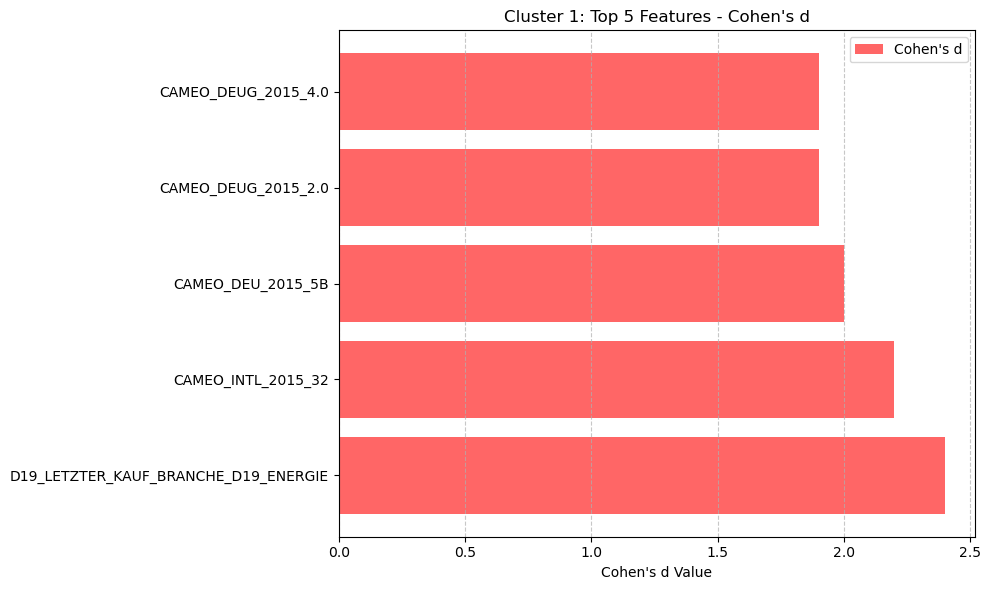

In [179]:
# Cluster 1
# Sort by the absolute value of Cohen's d in descending order and select the top 20
top_5_features = cluster_1_results.reindex(cluster_1_results['Cohen\'s d'].sort_values(ascending=False).head(5).index)

# Plotting only Cohen's d for the top 20 features
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Cohen's d
ax.barh(top_5_features['Feature'], top_5_features['Cohen\'s d'], color='red', alpha=0.6, label="Cohen's d")

# Adding labels and title
ax.set_xlabel('Cohen\'s d Value')
ax.set_title('Cluster 1: Top 5 Features - Cohen\'s d')

# Adding grid and legend
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()


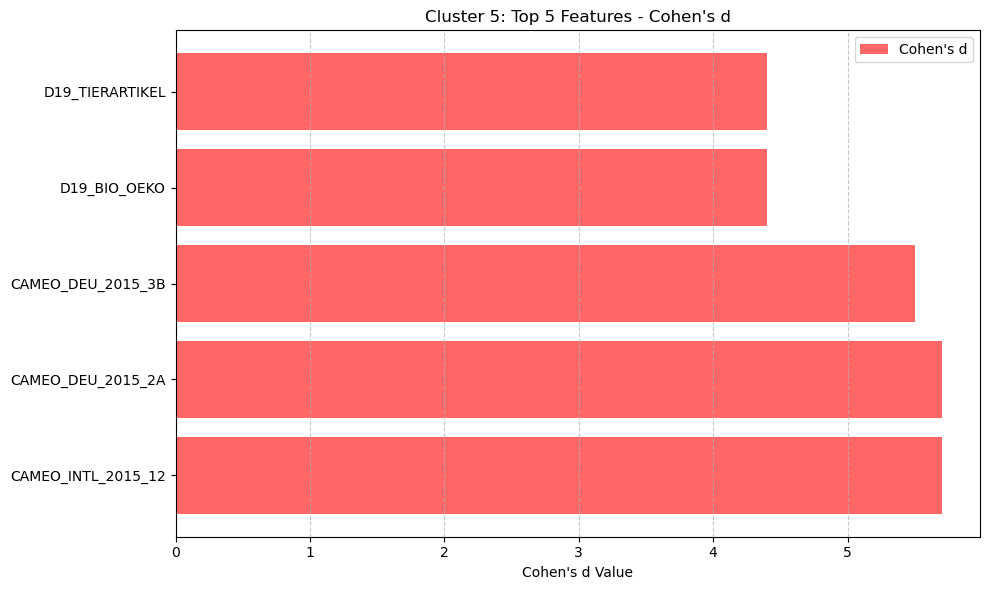

In [180]:
# Cluster 5
# Sort by the absolute value of Cohen's d in descending order and select the top 20
top_5_features = cluster_5_results.reindex(cluster_5_results['Cohen\'s d'].sort_values(ascending=False).head(5).index)

# Plotting only Cohen's d for the top 20 features
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Cohen's d
ax.barh(top_5_features['Feature'], top_5_features['Cohen\'s d'], color='red', alpha=0.6, label="Cohen's d")

# Adding labels and title
ax.set_xlabel('Cohen\'s d Value')
ax.set_title('Cluster 5: Top 5 Features - Cohen\'s d')

# Adding grid and legend
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()


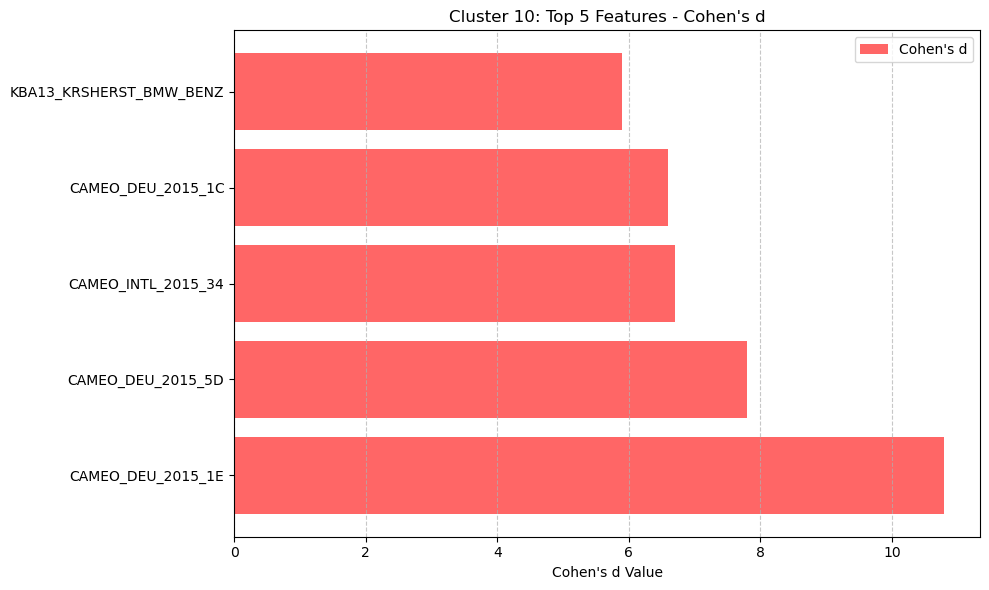

In [181]:
# Cluster 10
# Sort by the absolute value of Cohen's d in descending order and select the top 20
top_5_features = cluster_10_results.reindex(cluster_10_results['Cohen\'s d'].sort_values(ascending=False).head(5).index)

# Plotting only Cohen's d for the top 20 features
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Cohen's d
ax.barh(top_5_features['Feature'], top_5_features['Cohen\'s d'], color='red', alpha=0.6, label="Cohen's d")

# Adding labels and title
ax.set_xlabel('Cohen\'s d Value')
ax.set_title('Cluster 10: Top 5 Features - Cohen\'s d')

# Adding grid and legend
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately qual parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [423]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/var/folders/df/vskq6r65025_c31r_18tdcpr0000gn/T/ipykernel_8402/2624572247.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [424]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/var/folders/df/vskq6r65025_c31r_18tdcpr0000gn/T/ipykernel_8402/4118961090.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')


In [425]:
mailout_train.shape

(42962, 367)

In [426]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [427]:
mailout_train.isna().sum()

LNR                                0
AGER_TYP                           0
AKT_DAT_KL                      6969
ALTER_HH                        6969
ALTER_KIND1                    40974
ALTER_KIND2                    42206
ALTER_KIND3                    42788
ALTER_KIND4                    42921
ALTERSKATEGORIE_FEIN            8155
ANZ_HAUSHALTE_AKTIV             7777
ANZ_HH_TITEL                    8246
ANZ_KINDER                      6969
ANZ_PERSONEN                    6969
ANZ_STATISTISCHE_HAUSHALTE      7777
ANZ_TITEL                       6969
ARBEIT                          7951
BALLRAUM                        7799
CAMEO_DEU_2015                  7888
CAMEO_DEUG_2015                 7888
CAMEO_INTL_2015                 7888
CJT_GESAMTTYP                    605
CJT_KATALOGNUTZER                605
CJT_TYP_1                        605
CJT_TYP_2                        605
CJT_TYP_3                        605
CJT_TYP_4                        605
CJT_TYP_5                        605
C

In [428]:
mailout_test.head()


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [429]:
clean_mailout_train = clean_nulls(mailout_train,exclude_cols=['LNR','RESPONSE'])

Dropping columns with more than 50% Null values: ['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'KK_KUNDENTYP']
Numerical columns' nulls have been successfully replaced with the respective column's mean.
Categorical columns' nulls have been successfully replaced with the respective column's mode.
Remaining Nulls in df: 0


/var/folders/df/vskq6r65025_c31r_18tdcpr0000gn/T/ipykernel_8402/3518670280.py:88: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(most_frequent_value, inplace=True)


In [430]:
clean_mailout_test = clean_nulls(mailout_test,exclude_cols=['LNR'])

Dropping columns with more than 50% Null values: ['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'KK_KUNDENTYP']
Numerical columns' nulls have been successfully replaced with the respective column's mean.
Categorical columns' nulls have been successfully replaced with the respective column's mode.
Remaining Nulls in df: 0


/var/folders/df/vskq6r65025_c31r_18tdcpr0000gn/T/ipykernel_8402/3518670280.py:88: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(most_frequent_value, inplace=True)


In [431]:
# Exclude specific columns to create `df_train` and 'df_test' for customer segment and population segment.
df_train = clean_mailout_train.drop(columns=['LNR','EINGEFUEGT_AM'])
df_test = clean_mailout_test.drop(columns=['LNR','EINGEFUEGT_AM'])


In [432]:
df_train.select_dtypes(include=['object']).columns


Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'],
      dtype='object')

In [433]:
df_test.select_dtypes(include=['object']).columns


Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'],
      dtype='object')

In [434]:
# List of columns to one-hot encode
columns_to_encode = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 
                     'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ']

# One-hot encoding the specified columns
df_train_encoded = pd.get_dummies(df_train, columns=columns_to_encode, drop_first=True)

# Check the result
df_train_encoded.columns


Index(['AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL',
       ...
       'D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK',
       'D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE',
       'D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST',
       'D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL',
       'D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT',
       'D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST',
       'D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN',
       'D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT',
       'D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST', 'OST_WEST_KZ_W'],
      dtype='object', length=494)

In [435]:
# List of columns to one-hot encode
columns_to_encode = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 
                     'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ']

# One-hot encoding the specified columns
df_test_encoded = pd.get_dummies(df_test, columns=columns_to_encode, drop_first=True)

# Check the result
df_test_encoded.columns


Index(['AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL',
       ...
       'D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK',
       'D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE',
       'D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST',
       'D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL',
       'D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT',
       'D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST',
       'D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN',
       'D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT',
       'D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST', 'OST_WEST_KZ_W'],
      dtype='object', length=493)

In [436]:
df_test_encoded.shape


(42833, 493)

In [437]:
df_train_encoded.shape


(42962, 494)

In [438]:
extra_column = set(df_train_encoded.columns) - set(df_test_encoded.columns)
extra_column

{'RESPONSE'}

In [439]:
# Separate features and target
X = df_train_encoded.drop(columns='RESPONSE')
y = df_train_encoded['RESPONSE']
test = df_test_encoded

In [183]:
mailout_scaler = StandardScaler()
X_scaled = mailout_scaler.fit_transform(X)
test_scaled = mailout_scaler.transform(test)

In [184]:
# Split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())

Before SMOTE: RESPONSE
0    33943
1      426
Name: count, dtype: int64
After SMOTE: RESPONSE
0    33943
1    33943
Name: count, dtype: int64


In [185]:



def plot_learning_curve(estimator, X, y, scoring='roc_auc', cv=5):
    
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, valid_mean, 'o-', color="g", label="Validation score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.1, color="g")
    plt.xlabel("Training set size")
    plt.ylabel(scoring.capitalize())
    plt.title(f"Learning Curve ({estimator.__class__.__name__})")
    plt.legend(loc="best")
    plt.grid()
    plt.show()





/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

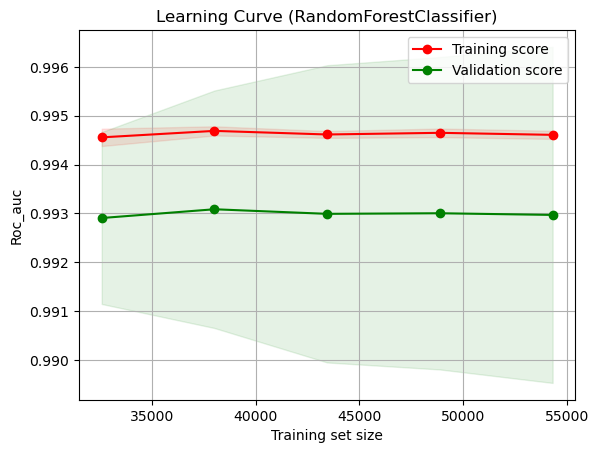

In [186]:
plot_learning_curve(RandomForestClassifier(), X_train_smote, y_train_smote, scoring='roc_auc', cv=5)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

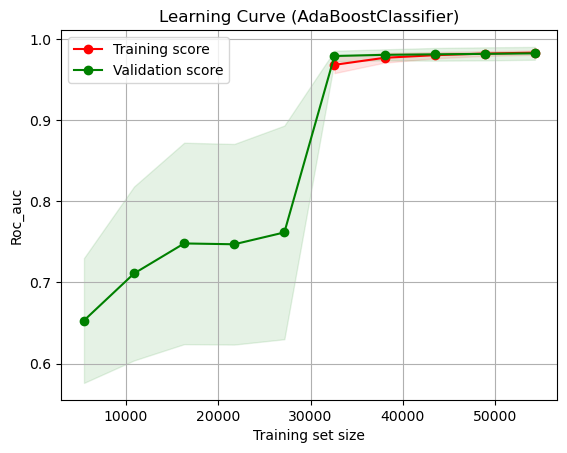

In [187]:
plot_learning_curve(AdaBoostClassifier(), X_train_smote, y_train_smote, scoring='roc_auc', cv=5)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py", line 665, in fit
    y = self._encode_y(

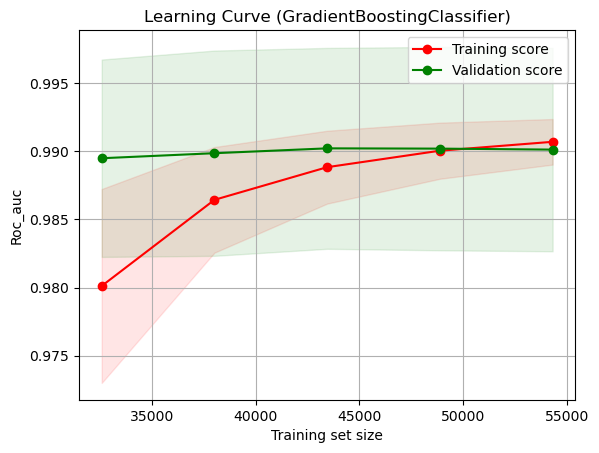

In [188]:
plot_learning_curve(GradientBoostingClassifier(), X_train_smote, y_train_smote, scoring='roc_auc', cv=5)

In [203]:
ada = AdaBoostClassifier(random_state=42)

In [204]:
ada.get_params()


{'algorithm': 'SAMME.R',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 42}

In [209]:


# Define parameter search space
param_space_ada = {
    'n_estimators': (50, 300),                     # Number of boosting rounds
    'learning_rate': (0.01, 1.0, 'log-uniform')   # Learning rate
}




# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=ada,
    search_spaces=param_space_ada,
    scoring='roc_auc',               # Optimize for ROC AUC
    cv=5,
    n_iter=32,                       # Number of iterations for the search
    random_state=42,
    n_jobs=-1                         # Use all processors
)


In [210]:
start_time = time.time()
# Run Bayesian search
bayes_search.fit(X_train_smote, y_train_smote)

end_time = time.time()

# Output best parameters and score
print("Best Parameters:", bayes_search.best_params_)
print("Best ROC AUC Score:", bayes_search.best_score_)

duration = (end_time - start_time)/60
print(duration)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

Best Parameters: OrderedDict({'learning_rate': 0.5223032564995028, 'n_estimators': 299})
Best ROC AUC Score: 0.9883554816228293
128.135429418087


In [248]:
best_model = bayes_search.best_estimator_
print("Best model:", best_model)
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

print(roc_auc_score(y_test, y_pred))

Best model: AdaBoostClassifier(learning_rate=0.5223032564995028, n_estimators=299,
                   random_state=42)
0.5227717863724987


In [250]:
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc:.3f}")


# Step 4: Optional - Generate ROC Curve details to analyze thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)


# Set a custom threshold based on analysis, such as maximizing a particular metric
threshold = 0.55

# Adjust predictions using custom threshold
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)


# Step 5: Calculate and display precision-focused metrics at the custom threshold
precision = precision_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)

print(f"Metrics at threshold {threshold}:")
print(f" - Precision: {precision:.3f}")
print(f" - Recall: {recall:.3f}")
print(f" - F1 Score: {f1:.3f}")
print(f"Classification Report at threshold {threshold}:\n{classification_report(y_test, y_pred_adjusted)}")



ROC AUC Score: 0.660
Metrics at threshold 0.55:
 - Precision: 0.000
 - Recall: 0.000
 - F1 Score: 0.000
Classification Report at threshold 0.55:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8487
           1       0.00      0.00      0.00       106

    accuracy                           0.99      8593
   macro avg       0.49      0.50      0.50      8593
weighted avg       0.98      0.99      0.98      8593



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/s

#### Iteration 2: AdaBoostClf - SMOTE + PCA

In [237]:
clf_pca = PCA(n_components=239,random_state=42)


In [238]:
X_train_pca = clf_pca.fit_transform(X_train_smote)
X_test_pca = clf_pca.transform(X_test)


In [239]:
ada_pca = AdaBoostClassifier(learning_rate=0.5223032564995028, n_estimators=299,random_state=42)

In [240]:
start_time = time.time()
print(start_time)
ada_pca.fit(X_train_pca, y_train_smote)
end_time = time.time()
print(end_time)
duration = (end_time - start_time)/60
print(duration)


1731366544.44497


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


1731367014.97418
7.84215350151062


In [252]:
y_pred = ada_pca.predict(X_test_pca)
y_pred_prob = ada_pca.predict_proba(X_test_pca)[:, 1]  # Probabilities for the positive class
print(roc_auc_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_prob))

0.5352414680832616
0.5739388320872545


#### Iteration 3: AdaBoost - SMOTE + Base Estimator (DecisionTreeClassifier)

In [389]:
# Define the base estimator (weak learner) - Decision Tree with a small max depth
base_estimator = DecisionTreeClassifier(max_depth=1)  # Typically, a small depth is used

# Define the AdaBoost model
adaboost_model_3 = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=50,  # Number of weak learners to train
    learning_rate=1.0,
    random_state=42
)

# Fit the model on the training data
adaboost_model_3.fit(X_train_smote, y_train_smote)

# Predict on the test data
y_pred = adaboost_model_3.predict(X_test)
y_pred_prob = adaboost_model_3.predict_proba(X_test)[:, 1]  # For ROC AUC calculation

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.3f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob):.3f}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      8487
           1       0.03      0.06      0.04       106

    accuracy                           0.96      8593
   macro avg       0.51      0.52      0.51      8593
weighted avg       0.98      0.96      0.97      8593

Accuracy: 0.963
ROC AUC Score: 0.515
ROC AUC Score: 0.682


#### Iteration 4: AdaBoost - SMOTE + PCA + Base Estimator (DecisionTreeClassifier)

In [390]:
# Define the base estimator (weak learner) - Decision Tree with a small max depth
base_estimator = DecisionTreeClassifier(max_depth=1)  # Typically, a small depth is used

# Define the AdaBoost model
adaboost_model = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=50,  # Number of weak learners to train
    learning_rate=1.0,
    random_state=42
)

# Fit the model on the training data
adaboost_model.fit(X_train_pca, y_train_smote)

# Predict on the test data
y_pred = adaboost_model.predict(X_test_pca)
y_pred_prob = adaboost_model.predict_proba(X_test_pca)[:, 1]  # For ROC AUC calculation

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.3f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob):.3f}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      8487
           1       0.02      0.20      0.03       106

    accuracy                           0.84      8593
   macro avg       0.50      0.53      0.47      8593
weighted avg       0.98      0.84      0.90      8593

Accuracy: 0.845
ROC AUC Score: 0.525
ROC AUC Score: 0.560


### ROC AUC Evaluation:

1. Iteration 1: BayesSearchCV + SMOTE -- 0.66
2. Iteration 2: AdaBoost + SMOTE + PCA -- 0.57
3. Iteration 3: AdaBoost + SMOTE + Base Estimator (DecisionTreeClassifier) -- 0.68 **(WINNER)**
4. Iteration 4: AdaBoost + SMOTE + PCA + Base Estimator (DecisionTreeClassifier) -- 0.56



In [440]:
# Generate predictions
prediction = adaboost_model_3.predict(test_scaled)


In [442]:
# Convert the predictions (which are a NumPy array) to a pandas DataFrame
prediction_df = pd.DataFrame(prediction, columns=['Prediction'])

# Save the DataFrame with predictions as 'results.csv'
prediction_df.to_csv('results.csv', index=False)

print("Results saved to 'results.csv'")


Results saved to 'results.csv'
